In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from implementations import *
from helpers import *
from classifiers import *

In [3]:
from proj1_helpers import *

DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


## Split data

In [4]:
def split_data(X, y=None):
    """
    Splits the data matrix X into partitions based on the integer feature 'PRI_jet_num'
    
    :param X: examples
    :param y: labels
    :return indices of split for every subset, X_split, y_split
    """
    # features
    undef_feature_for = {
        'DER_deltaeta_jet_jet'   : [0, 1],
        'DER_mass_jet_jet'       : [0, 1],
        'DER_prodeta_jet_jet'    : [0, 1],
        'DER_lep_eta_centrality' : [0, 1],
        'PRI_jet_num'            : [0, 1, 2, 3],
        'PRI_jet_leading_pt'     : [0],
        'PRI_jet_leading_eta'    : [0],
        'PRI_jet_leading_phi'    : [0],
        'PRI_jet_subleading_pt'  : [0, 1],
        'PRI_jet_subleading_eta' : [0, 1],
        'PRI_jet_subleading_phi' : [0, 1],
        'PRI_jet_all_pt'         : [0]
    }

    # the feature based on which we split tX
    jet_num_feature = "PRI_jet_num"
    jet_levels = 4

    # build valid features for every subset of tX
    features_split = []
    for jet in range(jet_levels):
        valid_features = [ f for f in features if not ((f in undef_feature_for) and (jet in undef_feature_for[f])) ]
        features_split.append(valid_features)
        
    # split data based on jet level (vertical split)
    split_indices = [
        X[:,features.index(jet_num_feature)] == i for i in range(jet_levels)
    ]
    X_split = [
        X[X[:,features.index(jet_num_feature)] == i,:] for i in range(jet_levels)
    ]
    if y is None:
        y_split = None
    else:
        y_split = [
            y[X[:,features.index(jet_num_feature)] == i] for i in range(jet_levels)
        ]

    # only keep relevant features (horizontal split)
    for i, X_ in enumerate(X_split):
        indices = [ features.index(feature) for feature in features_split[i] ]
        indices_bool = [ e in indices for e in range(len(features)) ]
        X_split[i] = X_[:,indices_bool]
        
    return split_indices, X_split, y_split

In [18]:
def build_poly_no_interaction(X, degree):
    """
    Build a polynomial expansion of X without interaction terms
    
    :param X: data
    :param degree: degree of expansion
    :return the expanded data
    """
    result = X.copy()
    for d in range(2, degree+1):
        # faster than np.power()
        power = X.copy()
        for i in range(d - 1):
            power = power * X
            
        result = np.hstack((result, power))
        
    return result

def build_X(X, d_int, d_sq):
    """
    Expands X with integer and/or half-powers
    
    :param X: examples
    :param d_int: degree of integer powers
    :param d_sq: ceil of degree of half-powers (expansion will be up to d_sq - 0.5)
    
    """
    X_ = remove_NaN_features(X, 0.2)
    X_, mean_, std_ = standardize(X_)
    
    ints = []
    sqrts = []
    
    # build integer powers
    if d_int > 0:
        ints = build_poly_no_interaction(X_, d_int)
      
    # build half-powers (0.5, 1.5, 2.5, etc.)
    if d_sq > 0:
        sqrts = np.sqrt(np.abs(X_))
        if d_sq > 1:
            width = sqrts.shape[1]
            int_power = np.abs(build_poly_no_interaction(X_, d_sq - 1))
            
            half_power = sqrts.copy()
            for i in range(d_sq - 1):
                half_power = np.hstack((half_power, sqrts * int_power[:,(width*i):(width*(i+1))]))
                
            sqrts = np.hstack((sqrts, half_power))
    else:
        return ints

    # concat
    X_ = np.hstack((ints, sqrts))
    return X_

In [6]:
indices_split, X_split, y_split = split_data(tX, y)

## Test different models

In [ ]:
# try different models
# LeastSquaresL2 is by far the best

X_split_poly = [ build_X(X, 11, 3) for X in X_split ]
lambda_ = 1e-8
k = 5
models_try = [
    LeastSquaresL2(lambda_),
    LeastSquaresL1(lambda_, verbose=True, max_evaluations=500),
    LogisticRegression(),
    LogisticRegressionL2(lambda_),
    LogisticRegressionL1(lambda_, verbose=True, max_evaluations=500),
]
total_accs = []

for model in models_try:
    
    accuracies = []
    # iterate over 4 sub datasets
    for i in range(len(X_split_poly)):
        acc = np.mean(cross_validate_kfold(y_split[i], X_split_poly[i], model, 5))
        accuracies.append(acc)
        
    # compute mean (weighted)
    accuracy = 0
    for i, acc in enumerate(accuracies):
        accuracy += acc * len(y_split[i])
    accuracy /= len(y) 
    
    total_accs.append(accuracy)
    
plt.plot(["LS L2", "LS L1", "LogReg", "LogReg L2", "LogReg L1"], total_accs)

## Grid search for rough estimate of best integer power, best half power and best lambda

In [ ]:
# find best lambda_ or degree

d_ints = range(11, 12)
d_sqs = range(3, 4)
#lambdas = [ math.pow(10,c) for c in np.linspace(-8,-7.5,200) ]
lambdas = np.linspace(1.41e-08,1.47e-08,200)

max_train = 0
max_train_d_int = 0
max_train_d_sq = 0
max_train_d_lambda = 0

max_test = 0
max_test_d_int = 0
max_test_d_sq = 0
max_test_d_lambda = 0

for d_int in d_ints:
    for d_sq in d_sqs:
        X_split_poly = [ build_X(X, d_int, d_sq) for X in X_split ]
        X_test_split_poly = [ build_X(X, d_int, d_sq) for X in X_test_split ]
        
        for lambda_ in lambdas:
            
            models = []
            y_pred = np.ones(tX.shape[0])

            for i in range(len(X_split_poly)):
                lse = LeastSquaresL2(lambda_)
                lse.fit(y_split[i], X_split_poly[i])
                models.append(lse)
                y_pred[indices_split[i]] = lse.predict(X_split_poly[i])

            acc_train = np.mean(y == y_pred)
            if acc_train > max_train:
                max_train = acc_train
                max_train_d_int = d_int
                max_train_d_sq = d_sq
                max_train_d_lambda = lambda_
            
            print(f"d_int={d_int}, d_sq={d_sq}, lambda_={lambda_} - train={acc_train}")
            

## Cross-validation to optimize the hyper-parameter lambda

lambda=1.41e-08 -  - 0.8281143389989235
lambda=1.4112244897959185e-08 -  - 0.8280943366145741
lambda=1.4124489795918368e-08 -  - 0.8280863368827237
lambda=1.4136734693877551e-08 -  - 0.8281143391713977
lambda=1.4148979591836735e-08 -  - 0.828094336019971
lambda=1.4161224489795919e-08 -  - 0.8280703353765034
lambda=1.4173469387755103e-08 -  - 0.8280863362881208
lambda=1.4185714285714287e-08 -  - 0.828058334335339
lambda=1.4197959183673469e-08 -  - 0.8280943377175431
lambda=1.4210204081632653e-08 -  - 0.8280743349882453
lambda=1.4222448979591837e-08 -  - 0.8281103394734185
lambda=1.4234693877551021e-08 -  - 0.8280983373292851
lambda=1.4246938775510205e-08 -  - 0.8280783357891935
lambda=1.4259183673469387e-08 -  - 0.8280863367964869
lambda=1.4271428571428571e-08 -  - 0.8280983384322542
lambda=1.4283673469387755e-08 -  - 0.8280983372430482
lambda=1.429591836734694e-08 -  - 0.8280983375879962
lambda=1.4308163265306123e-08 -  - 0.8280983386047284
lambda=1.4320408163265306e-08 -  - 0.82807433

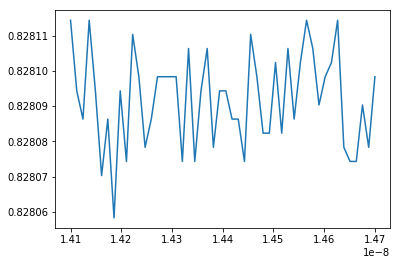

In [36]:
# cross_validate
total_acc = []
k = 10
lambdas = np.linspace(1.41e-08,1.47e-08,50)
d_int = 11
d_sq = 3

X_split_poly = [ build_X(X, d_int, d_sq) for X in X_split ]

# run that shit
for lambda_ in lambdas:
    print(f"lambda={lambda_}", end=" - ")
    
    accuracies = []
    
    # iterate over 4 sub datasets
    for i in range(len(X_split_poly)):
        classifier = LeastSquaresL2(lambda_)
        acc = np.mean(cross_validate_kfold(y_split[i], X_split_poly[i], classifier, k))
        accuracies.append(acc)
        
    # compute mean (weighted)
    accuracy = 0
    for i, acc in enumerate(accuracies):
        accuracy += acc * len(y_split[i])
    accuracy /= len(y)
        
    print(accuracy)
    total_acc.append(accuracy)
    
plt.plot(lambdas, total_acc)
best_lambdas = [ lambdas[index] for index in np.argpartition(total_acc, -4)[-4:] ]

In [48]:
# find the best lambda
best_lambdas = [ lambdas[index] for index in np.argpartition(total_acc, -4)[-4:] ]
best_lambda = best_lambdas[0]

## Train final model

In [64]:
# train actual models
# degrees 11,3 seem to be best

best_lambda = 1.4565306122448979e-08
best_deg_int = 11
best_deg_sq = 3


def model_split_data(X):
    return build_X(X, best_deg_int, best_deg_sq)

X_split_poly = [ model_split_data(X) for X in X_split ]
lambda_ = best_lambda
models = []
y_pred = np.ones(tX.shape[0])

for i in range(len(X_split_poly)):
    print(f"Building model for dataset {i}")
    lse = LeastSquaresL2(lambda_)
    lse.fit(y_split[i], X_split_poly[i])
    models.append(lse)
    y_pred[indices_split[i]] = lse.predict(X_split_poly[i])
    
print(np.mean(y == y_pred))

Building model for dataset 0
Building model for dataset 1
Building model for dataset 2
Building model for dataset 3
0.831044


## Try basic methods

In [52]:
X = remove_NaN_features(tX, 0.2)
X = replace_NaN_by_median(X)
X, _, _ = standardize(X)

In [60]:
lse_classifier = LeastSquares()
accuracy_lse = cross_validate(y, X, lse_classifier, 0.8, 10)
print(np.mean(accuracy_lse))

0.7093500000000001


In [53]:
def ridge_classifier(lambda_):
    return ridge_regression(y, X, lambda_)

lambda_ridge, _, _ = find_max_hyperparam(ridge_classifier, [10**c for c in range(-3,3)])
print("Optimal lambda: %f" % lambda_ridge)

Testing hyperparameter value 0.001000 - loss: 0.409
Testing hyperparameter value 0.010000 - loss: 0.412
Testing hyperparameter value 0.100000 - loss: 0.422
Testing hyperparameter value 1.000000 - loss: 0.451
Testing hyperparameter value 10.000000 - loss: 0.480
Testing hyperparameter value 100.000000 - loss: 0.497
Optimal lambda: 0.001000


In [58]:
ridge_classifier = LeastSquaresL2(lambda_ridge)
accuracy_ridge = cross_validate(y, X, ridge_classifier, 0.8, 10)
print(np.mean(accuracy_ridge))

0.705058


In [57]:
log_reg_classifier = LogisticRegression()
accuracy_log_reg = cross_validate(y, X, log_reg_classifier, 0.8, 10)
print(np.mean(accuracy_log_reg))

0.708392


In [59]:
def reg_log_reg_classifier(lambda_):
    return reg_logistic_regression(y, X, lambda_, np.zeros(X.shape[1]), 1000)

lambda_reg_log_reg, _, _ = find_max_hyperparam(reg_log_reg_classifier, [10**c for c in range(-3,3)])
print("Optimal lambda: %f" % lambda_reg_log_reg)

Testing hyperparameter value 0.001000 - loss: 146141.053
Testing hyperparameter value 0.010000 - loss: 145946.362
Testing hyperparameter value 0.100000 - loss: 146541.449
Testing hyperparameter value 1.000000 - loss: 146457.386
Testing hyperparameter value 10.000000 - loss: 147449.475
Testing hyperparameter value 100.000000 - loss: 148308.790
Optimal lambda: 0.010000


In [63]:
reg_log_reg_classifier = LogisticRegressionL2(lambda_reg_log_reg)
accuracy_log_reg = cross_validate(y, X, reg_log_reg_classifier, 0.8, 10)
print(np.mean(accuracy_log_reg))

0.708572


## Generate predictions and save ouput in csv format for submission:

In [9]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [10]:
test_split_indices, X_test_split, _ = split_data(tX_test)

In [65]:
# predictions using new model
X_test_split_poly = [ model_split_data(X) for X in X_test_split ]
y_pred = np.ones(tX_test.shape[0])

for model, X, indices in zip(models, X_test_split_poly, test_split_indices):
    y_pred[indices] = model.predict(X)

In [67]:
OUTPUT_PATH = '../results/predictions.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)